In [1]:
import matplotlib.patches as patches
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil
import sys
sys.path.append("..")

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set_theme(
    style="ticks", 
    font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"

from PJT_Frustration_Induced_Crystallize.main import *
from multiprocessing import Pool
import pandas as pd

colors = ["#403990", "#3A76D6", "#FFC001", "#F46F43", "#FF0000"]
cmap = mcolors.LinearSegmentedColormap.from_list("cmap", colors)
new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.hsv(np.linspace(0, 1, 256)) * 0.85, N=256
)

SAVE_PATH = r"F:\MS_ExperimentData\general"
MP4_PATH = r"F:\MS_ExperimentData\mp4"

# SAVE_PATH = r"D:\MS_ExperimentData\general"
# MP4_PATH = r"D:\MS_ExperimentData\mp4"

# LOCAL_FIG_PATH = "./PCT_C_figs"
LOCAL_FIG_PATH = "./figs"

In [2]:
model = PhaseLagPatternFormation(
    strengthK=10.5, distanceD0=1.067, phaseLagA0=0.6 * np.pi,
    omegaMin=0, deltaOmega=1,
    agentsNum=3000, dt=0.005,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
    randomSeed=10, overWrite=False
)
sa = StateAnalysis(model)

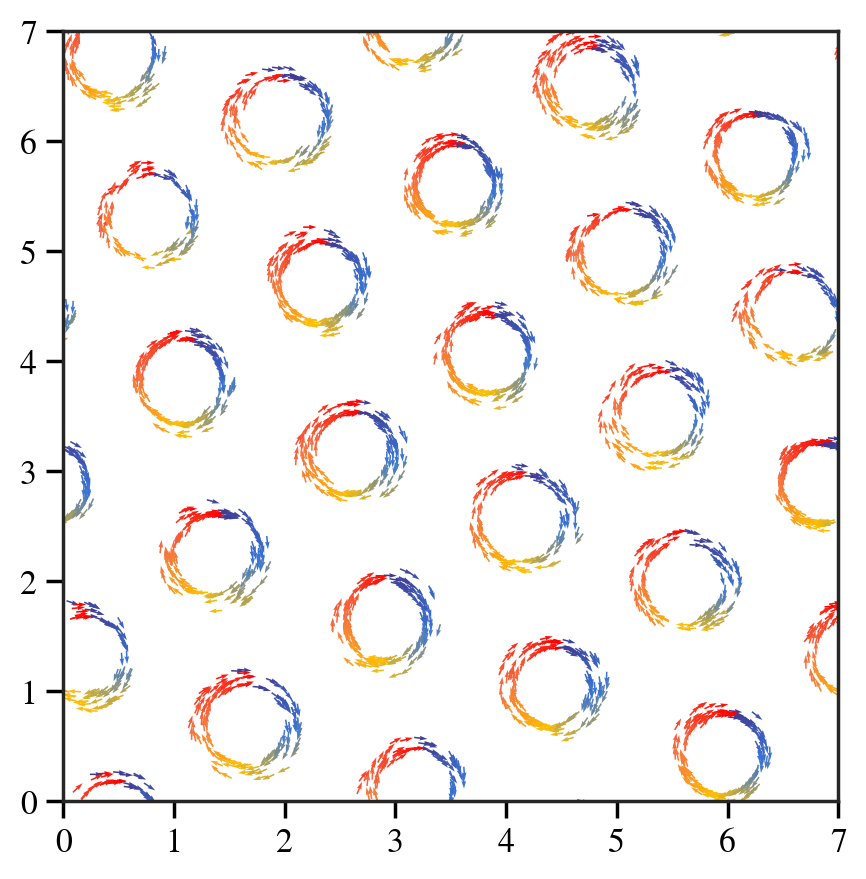

In [3]:
sa.plot_spatial()

In [6]:
shift = np.array([0., 0.])

classes, centers = sa.calc_classes_and_centers(classDistance=0.5, lookIdx=-1)
centers = np.mod(centers + shift, model.boundaryLength)

classCenters: List[np.ndarray] = []
for c in classes:
    singleClassCenters = centers[c]

    maxDeltaX = np.abs(singleClassCenters[:, 0] - singleClassCenters[:, 0, np.newaxis]).max()
    subXShift = model.halfBoundaryLength if maxDeltaX > model.halfBoundaryLength else 0
    maxDeltaY = np.abs(singleClassCenters[:, 1] - singleClassCenters[:, 1, np.newaxis]).max()
    subYShift = model.halfBoundaryLength if maxDeltaY > model.halfBoundaryLength else 0

    singleClassCenters = np.mod(singleClassCenters - np.array([subXShift, subYShift]), model.boundaryLength)
    classCenter = np.mod(singleClassCenters.mean(axis=0) + np.array([subXShift, subYShift]), model.boundaryLength)
    classCenters.append(classCenter)
classCenters: np.ndarray = np.array(classCenters)

edges, ajdClassCenters = sa.calc_nearby_edges(classCenters=classCenters, stdMulti=0.3)

In [38]:
reduceModels = list()

for classIdx in tqdm(range(len(classes))):

    reduceModel = PhaseLagPatternFormation(
        strengthK=model.strengthK, distanceD0=model.distanceD0, 
        phaseLagA0=model.phaseLagA0,
        # initPhaseTheta=np.zeros(1000), 
        omegaMin=0, deltaOmega=0,
        agentsNum=len(classes[classIdx]), dt=0.001,
        tqdm=True, savePath=SAVE_PATH, shotsnaps=10, 
        randomSeed=classIdx, overWrite=False
    )

    subIndexs = classes[classIdx]

    reduceModel.positionX = sa.totalPositionX[-1][subIndexs].copy()
    reduceModel.phaseTheta = sa.totalPhaseTheta[-1][subIndexs].copy()
    reduceModel.freqOmega = sa.model.freqOmega[subIndexs].copy()
    reduceModel.agentsNum = len(subIndexs)
    reduceModel.run(80000)
    reduceModels.append(reduceModel)

reduceSas = [StateAnalysis(reduceModel) for reduceModel in reduceModels]

  0%|          | 0/23 [00:00<?, ?it/s]

In [39]:
totalTvRadius = list()
totalReduceTvRadius = list()
step = 10

for idx, singleClass in enumerate(classes):
    subPositionX = sa.totalPositionX[::step, singleClass, :]
    reducePosX = reduceSas[idx].totalPositionX[::step, :, :]
    classCenter = classCenters[idx]
    tvMaxRadius = sa.calc_replative_distance(subPositionX, classCenter).mean(axis=1)
    reduceTvMaxRadius = sa.calc_replative_distance(reducePosX, classCenter).mean(axis=1)
    totalTvRadius.append(tvMaxRadius)
    totalReduceTvRadius.append(reduceTvMaxRadius)

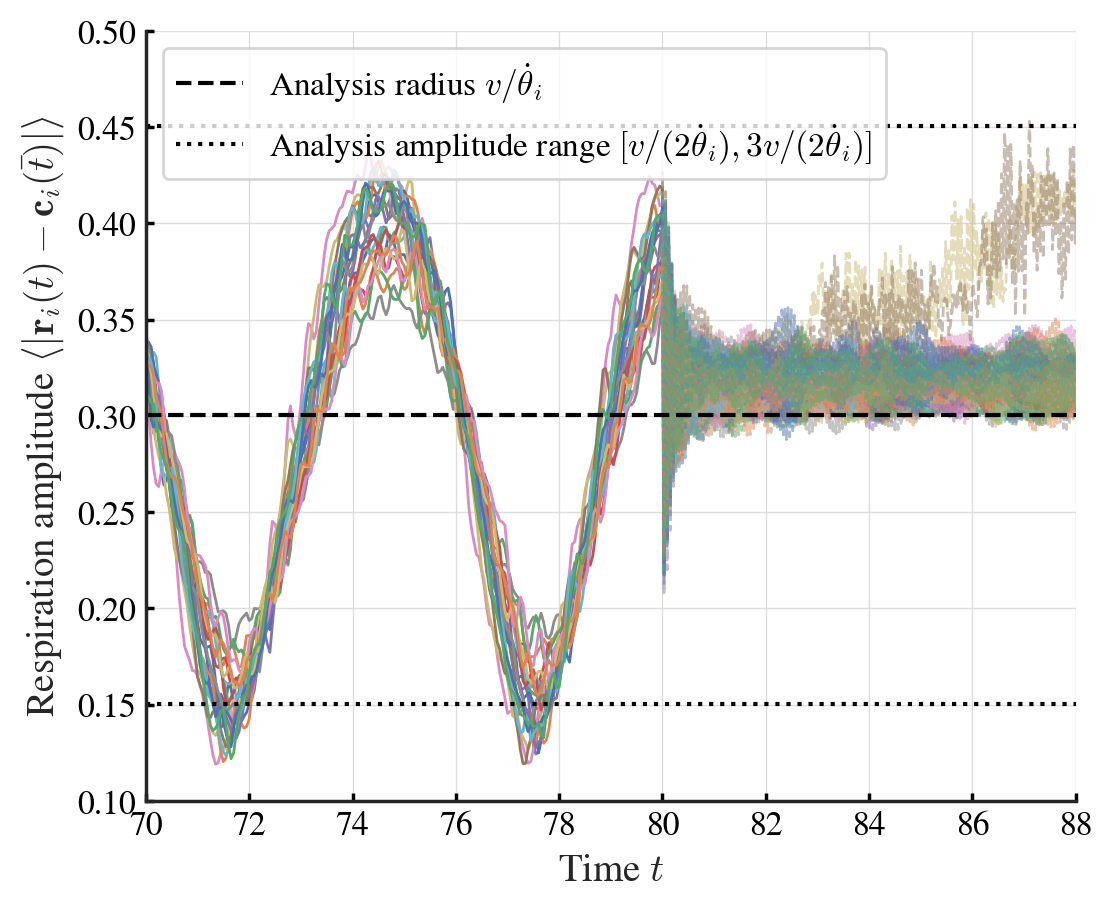

In [47]:
analysisRadius = model.speedV / np.abs(model.strengthK * np.sin(model.phaseLagA0))
tRanges = (np.arange(0, len(totalTvRadius[0])) * model.shotsnaps * model.dt)
reduceTRanges = (np.arange(0, len(totalReduceTvRadius[0])) * reduceModels[0].shotsnaps * reduceModels[0].dt) + tRanges.max()

for i, tvRadius in enumerate(totalTvRadius):
    plt.plot(tRanges, tvRadius, alpha=1, lw=1, color=f"C{i}")
    plt.plot(reduceTRanges, totalReduceTvRadius[i], alpha=0.5, lw=1, color=f"C{i}", ls="--")

plt.axhline(analysisRadius, color="black", lw=1.5, ls="--", label=r"Analysis radius $v/\dot{\theta}_i$")
plt.axhline(analysisRadius * 0.5, color="black", lw=1.5, ls=":")
plt.axhline(analysisRadius * 1.5, color="black", lw=1.5, ls=":", 
            label=r"Analysis amplitude range $[v/(2\dot{\theta}_i), 3v/(2\dot{\theta}_i)]$")
# plt.xlim(0, len(totalTvRadius[0]) - 1)
plt.tick_params(length=3, direction="in")
plt.xlabel("Time $t$", fontsize=14)
plt.ylabel(r"Respiration amplitude $\left< \left| \mathbf{r}_i(t)-\mathbf{c}_i(\bar{t}) \right| \right> $", fontsize=14)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.grid()
plt.xlim(70, 88)
plt.ylim(0.1, 0.5)
plt.legend(fontsize=12)
# plt.savefig("figs/respiration_amplitude.pdf", bbox_inches="tight")

In [34]:
tRanges

array([0.000e+00, 5.000e-02, 1.000e-01, ..., 7.990e+01, 7.995e+01,
       8.000e+01], shape=(1601,))

In [42]:
reduceTRanges

array([80.  , 80.01, 80.02, 80.03, 80.04, 80.05, 80.06, 80.07, 80.08,
       80.09, 80.1 , 80.11, 80.12, 80.13, 80.14, 80.15, 80.16, 80.17,
       80.18, 80.19, 80.2 , 80.21, 80.22, 80.23, 80.24, 80.25, 80.26,
       80.27, 80.28, 80.29, 80.3 , 80.31, 80.32, 80.33, 80.34, 80.35,
       80.36, 80.37, 80.38, 80.39, 80.4 , 80.41, 80.42, 80.43, 80.44,
       80.45, 80.46, 80.47, 80.48, 80.49, 80.5 , 80.51, 80.52, 80.53,
       80.54, 80.55, 80.56, 80.57, 80.58, 80.59, 80.6 , 80.61, 80.62,
       80.63, 80.64, 80.65, 80.66, 80.67, 80.68, 80.69, 80.7 , 80.71,
       80.72, 80.73, 80.74, 80.75, 80.76, 80.77, 80.78, 80.79, 80.8 ,
       80.81, 80.82, 80.83, 80.84, 80.85, 80.86, 80.87, 80.88, 80.89,
       80.9 , 80.91, 80.92, 80.93, 80.94, 80.95, 80.96, 80.97, 80.98,
       80.99, 81.  , 81.01, 81.02, 81.03, 81.04, 81.05, 81.06, 81.07,
       81.08, 81.09, 81.1 , 81.11, 81.12, 81.13, 81.14, 81.15, 81.16,
       81.17, 81.18, 81.19, 81.2 , 81.21, 81.22, 81.23, 81.24, 81.25,
       81.26, 81.27,

# Single cell trajectory

In [4]:
reduceModel = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    # initPhaseTheta=np.zeros(1000), 
    omegaMin=0, deltaOmega=0,
    agentsNum=102, dt=0.001,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=1, 
    randomSeed=9, overWrite=False
)
sa = StateAnalysis(reduceModel)

(4.0, 6.0)

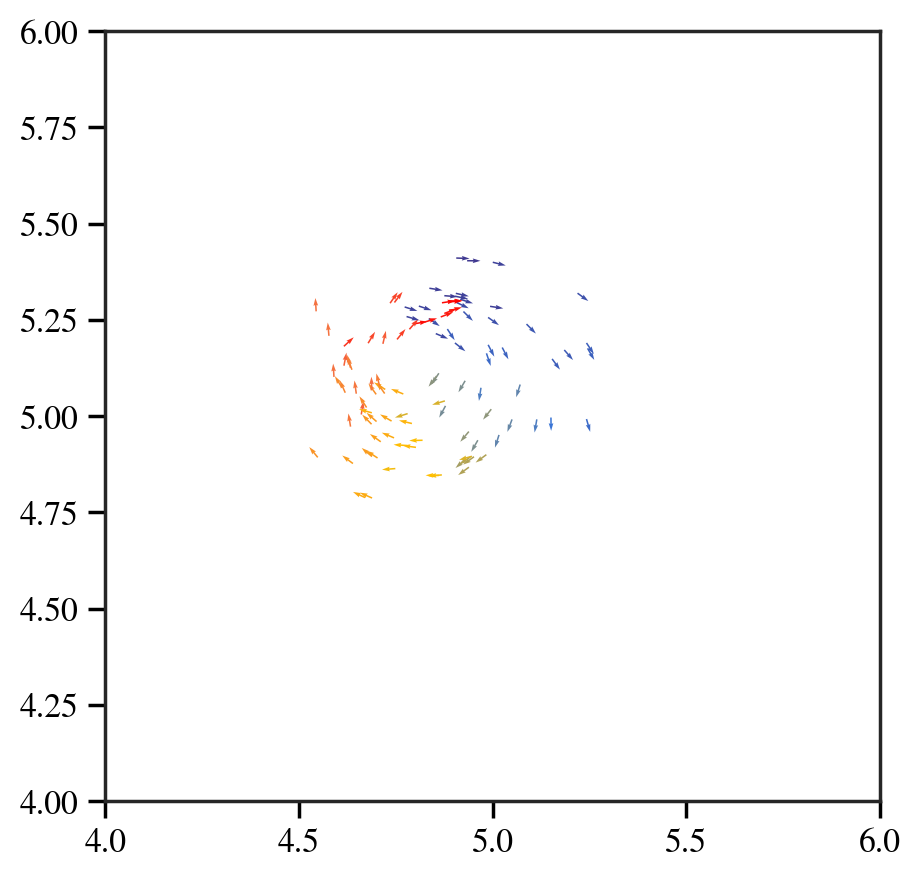

In [13]:
sa.plot_spatial(colorsBy="phase")
plt.xlim(4, 6)
plt.ylim(4, 6)

In [18]:
sa.totalPositionX.shape

(10000, 102, 2)

(4.0, 6.0)

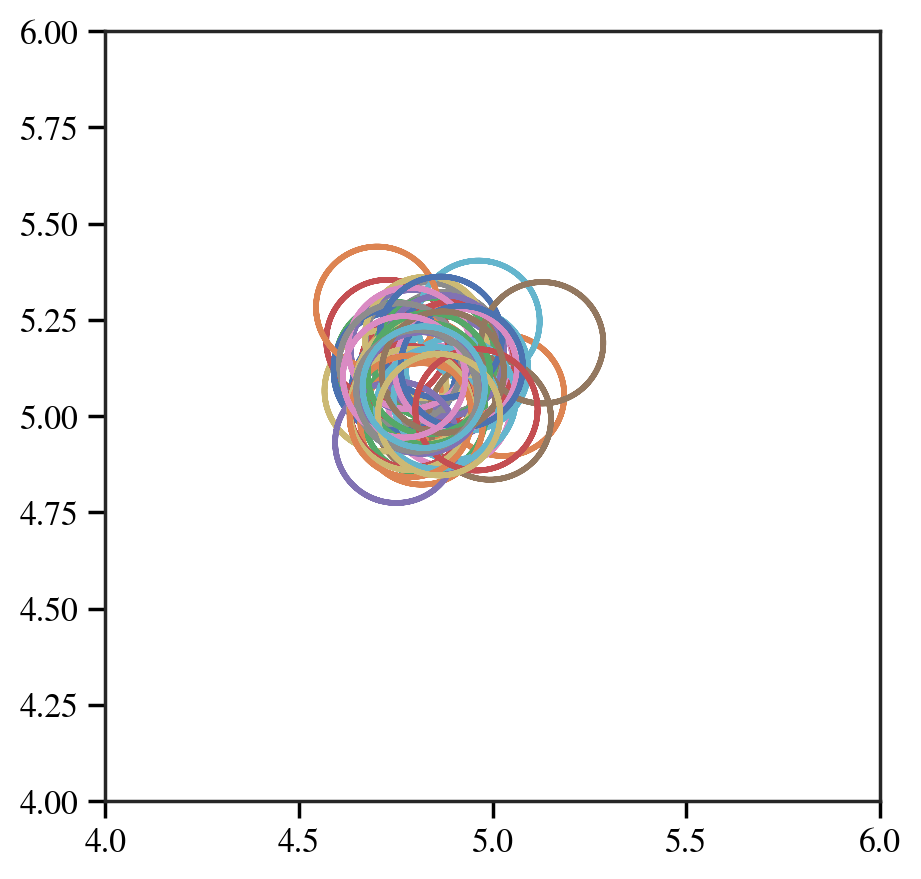

In [22]:
fig, ax = plt.subplots(figsize=(5, 5))

timeCounts = 1000
# trajectoryColors = ["#3A76D6", "#F46F43", "#FF0000", "#403990", "#FFC001"]
# for i, singleSelectIdx in enumerate([0, 5, 13, 75, 80]):
for i, singleSelectIdx in enumerate(range(50)):
    ax.plot(
        sa.totalPositionX[-timeCounts:, singleSelectIdx, 0],
        sa.totalPositionX[-timeCounts:, singleSelectIdx, 1],
        # color=trajectoryColors[i], 
        alpha=1, lw=2, zorder=0
    )

plt.xlim(4, 6)
plt.ylim(4, 6)

# Multi cells breathe sync

In [4]:
model = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    # initPhaseTheta=np.zeros(1000), 
    omegaMin=0, deltaOmega=0,
    agentsNum=3000, dt=0.005,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=1, 
    randomSeed=10, overWrite=False
)
sa = StateAnalysis(model)

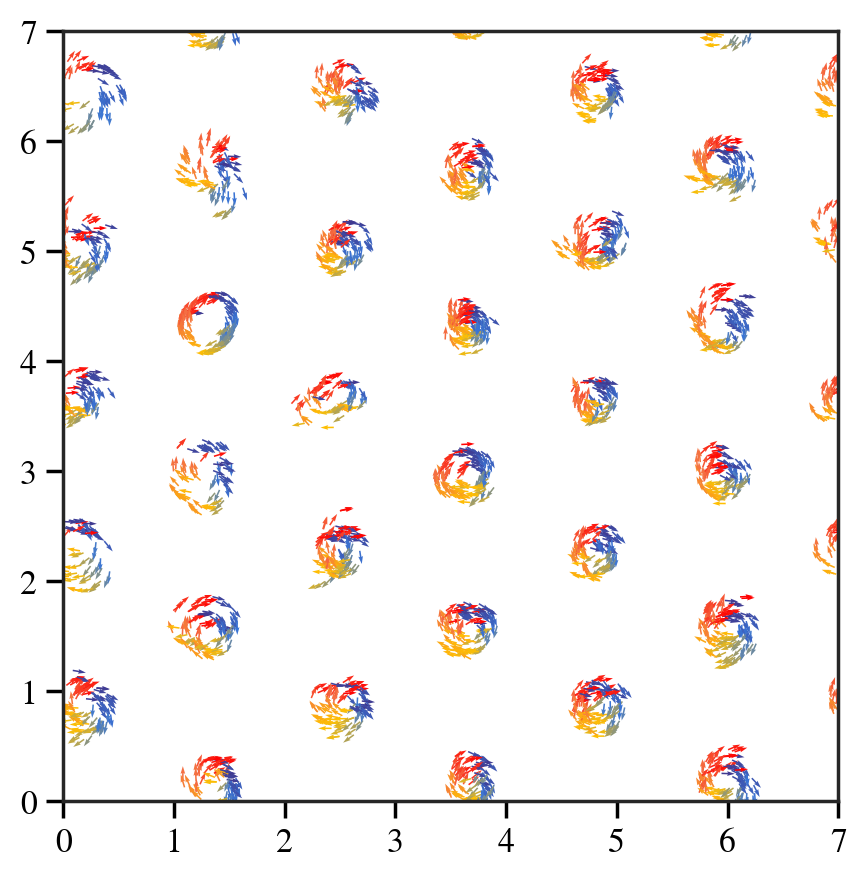

In [6]:
sa.plot_spatial(colorsBy="phase")

In [7]:
shift = np.array([0., 0.])

classes, centers = sa.calc_classes_and_centers(classDistance=0.5, lookIdx=-1)
centers = np.mod(centers + shift, model.boundaryLength)

classCenters: List[np.ndarray] = []
for c in classes:
    singleClassCenters = centers[c]

    maxDeltaX = np.abs(singleClassCenters[:, 0] - singleClassCenters[:, 0, np.newaxis]).max()
    subXShift = model.halfBoundaryLength if maxDeltaX > model.halfBoundaryLength else 0
    maxDeltaY = np.abs(singleClassCenters[:, 1] - singleClassCenters[:, 1, np.newaxis]).max()
    subYShift = model.halfBoundaryLength if maxDeltaY > model.halfBoundaryLength else 0

    singleClassCenters = np.mod(singleClassCenters - np.array([subXShift, subYShift]), model.boundaryLength)
    classCenter = np.mod(singleClassCenters.mean(axis=0) + np.array([subXShift, subYShift]), model.boundaryLength)
    classCenters.append(classCenter)
classCenters: np.ndarray = np.array(classCenters)

edgeLenThres = (
    model.distanceD0 + 
    2 * model.speedV / np.abs(model.freqOmega - model.strengthK * np.sin(model.phaseLagA0)).min()
) * 1.2
edges, ajdClassCenters = sa.calc_nearby_edges(classCenters=classCenters, stdMulti=0.3)

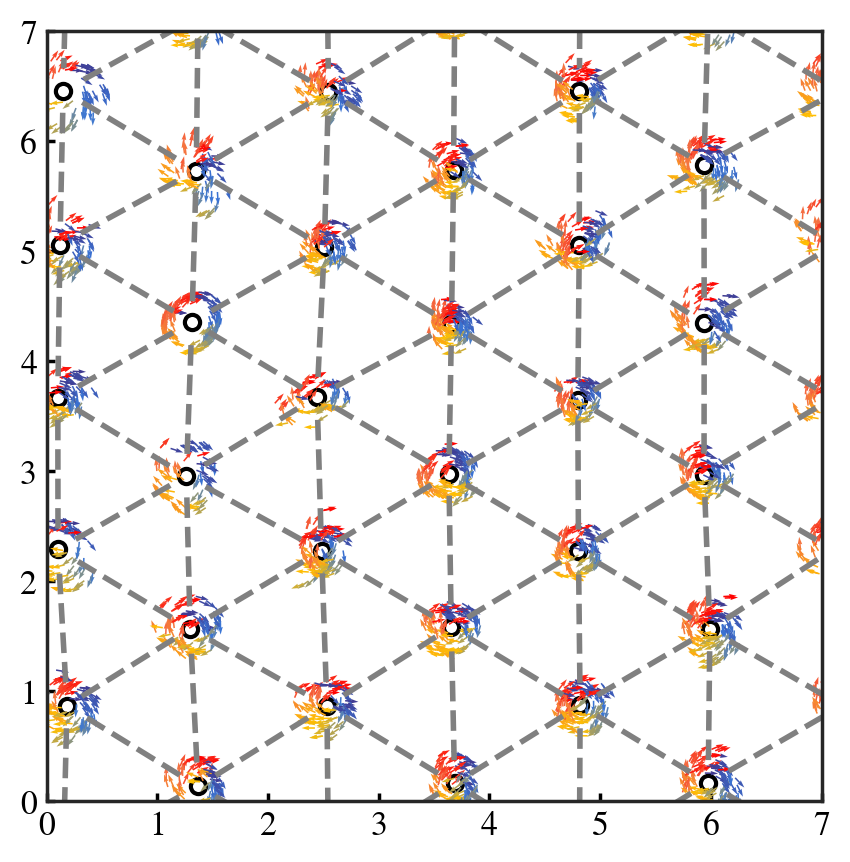

In [9]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.scatter(
    classCenters[:, 0], classCenters[:, 1],
    facecolor="white", s=30, edgecolor="black", lw=1.5
)

for edge in edges[:]:
    # plt.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1],
    #          color="black", lw=1.2, alpha=0.3, linestyle=(0, (10, 2)), zorder=0)
    edgeCenter = (ajdClassCenters[edge[0]] + ajdClassCenters[edge[1]]) / 2
    edgeNodesDelta = ajdClassCenters[edge[0]] - ajdClassCenters[edge[1]]
    edgeAngle = np.arctan2(edgeNodesDelta[1], edgeNodesDelta[0])
    edgeShift = np.array([np.cos(edgeAngle), np.sin(edgeAngle)]) * 0.5 * model.distanceD0

    plt.plot([edgeCenter[0] - edgeShift[0], edgeCenter[0] + edgeShift[0]], 
             [edgeCenter[1] - edgeShift[1], edgeCenter[1] + edgeShift[1]],
             lw=2, alpha=1, color="gray", ls="--")

analRadius = model.distanceD0 + 2 * model.speedV / np.abs(model.strengthK * np.sin(model.phaseLagA0))

for classCenter in classCenters:
    circle = plt.Circle(
        classCenter, analRadius, color="black", fill=False, lw=2, alpha=1, ls="--"
    )
    # ax.add_artist(circle)

sa.plot_spatial(ax=ax, colorsBy="phase", index=-1, shift=shift)

plt.tick_params(length=3, direction="in")

In [2]:
cellModel = CellAndSingleParticle(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    omegaMin=0, deltaOmega=0,
    agentsNum=100, dt=0.001,
    singleParticleDis=0.2, singleParticlePhase=0,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=5, 
    randomSeed=randomSeed, overWrite=False
)
cellModel.run(1000)
sa = StateAnalysis(cellModel)

F:\MS_ExperimentData\general/CellAndSingleParticle(strengthK=20.000,distanceD0=1.000,phaseLagA0=1.885,sPD=0.200,sPP=0.000,boundaryLength=7.0,speedV=3.0,omegaMin=0.000,deltaOmega=0.000,agentsNum=100,dt=0.001,shotsnaps=5,randomSeed=10).h5 already exists, but has only 201 snapshots, will continue to run until 202 snapshots.


  0%|          | 0/4 [00:00<?, ?it/s]

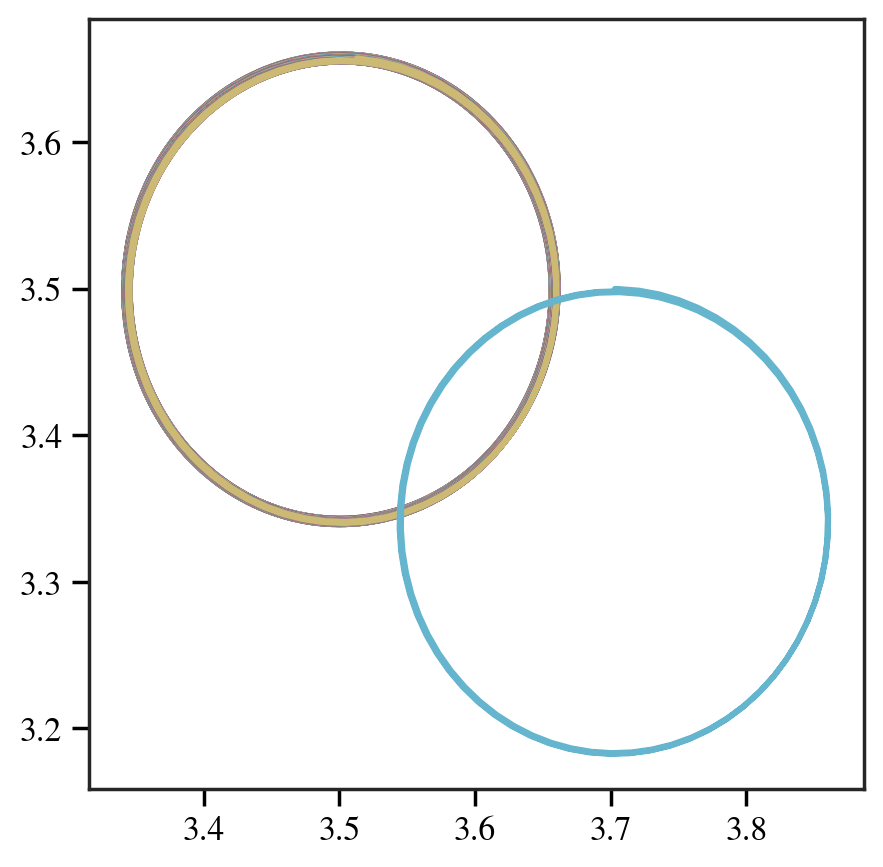

In [3]:
fig, ax = plt.subplots(figsize=(5, 5))

timeCounts = 1000
# trajectoryColors = ["#3A76D6", "#F46F43", "#FF0000", "#403990", "#FFC001"]
# for i, singleSelectIdx in enumerate([0, 5, 13, 75, 80]):
for i, singleSelectIdx in enumerate(range(cellModel.agentsNum)):
    ax.plot(
        sa.totalPositionX[-timeCounts:, singleSelectIdx, 0],
        sa.totalPositionX[-timeCounts:, singleSelectIdx, 1],
        # color=trajectoryColors[i], 
        alpha=1, lw=2, zorder=0
    )

# plt.xlim(4, 6)
# plt.ylim(4, 6)

In [49]:
strengthK = 20
distanceD0 = 1
phaseLagA0 = 0.6 * np.pi
speedV = 3
singleParticleDiss = np.linspace(0.1, distanceD0 + speedV / np.abs(strengthK * np.sin(phaseLagA0)), 21)
singleParticleAngles = np.linspace(-np.pi, np.pi, 20, endpoint=False)

models = [
    CellAndSingleParticle(
        strengthK=strengthK, distanceD0=distanceD0, phaseLagA0=phaseLagA0,
        singleParticleDis=singleParticleDis, singleParticleAngle=singleParticleAngle,
        agentsNum=100, dt=0.001,
        tqdm=False, savePath=SAVE_PATH, shotsnaps=5, 
        randomSeed=randomSeed, overWrite=False
    )
    for singleParticleDis in singleParticleDiss
    for singleParticleAngle in singleParticleAngles
]

(2.0, 5.0)

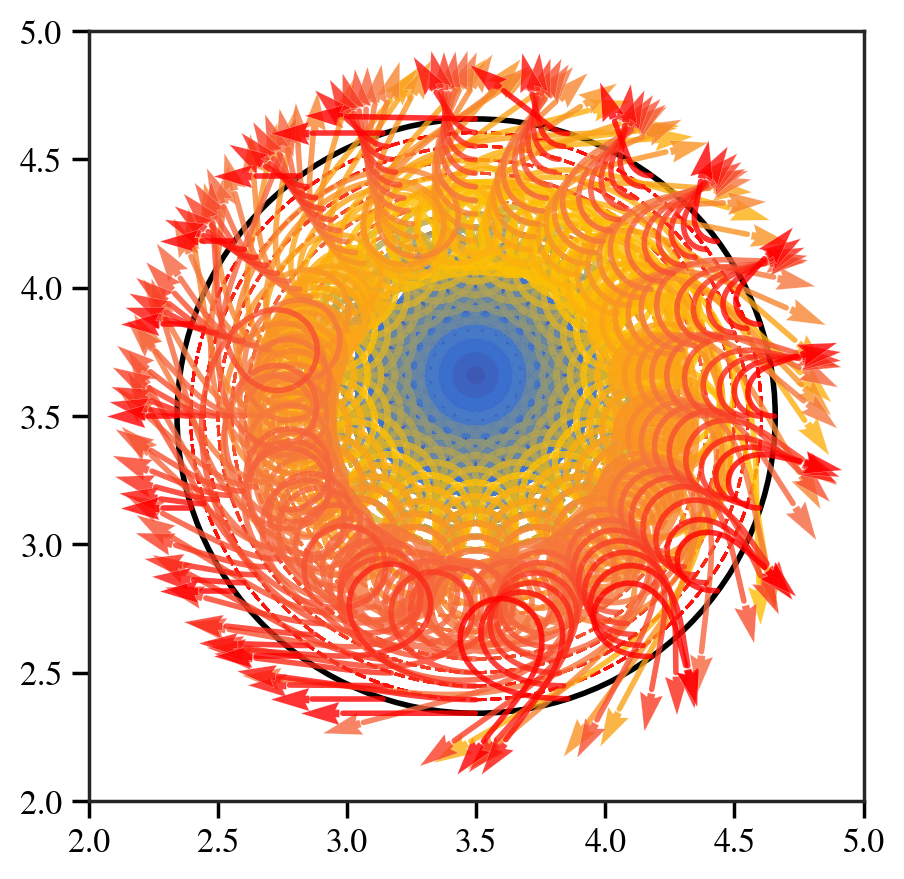

In [50]:
fig, ax = plt.subplots(figsize=(5, 5))
# model.plot(ax=ax, colorsBy="phase")
boxCenter = np.array([3.5, 3.5])
analRadius = speedV / np.abs(strengthK * np.sin(phaseLagA0))
disThres = (distanceD0 + analRadius) * 1.1
totalBreakThres = list()

for model in models[:]:

    sa = StateAnalysis(model)    
    sinParPos = sa.totalPositionX[:, -1]
    sinParPha = sa.totalPhaseTheta[:, -1]

    alpha = 0.8
    # alpha = 1 - (model.singleParticleDis / singleParticleDiss.max()) * 0.5
    # color = "C2"
    color = cmap(model.singleParticleDis / singleParticleDiss.max())

    circle = plt.Circle(boxCenter, model.singleParticleDis, color=color, 
                    fill=False, lw=1, alpha=1, ls="--")
    ax.add_artist(circle)

    centerDis = sa.calc_replative_distance(sinParPos, boxCenter)
    breakThres = np.where(centerDis > disThres)[0]
    if len(breakThres) == 0:
        plt.plot(sinParPos[:, 0], sinParPos[:, 1], color=color, lw=2, alpha=alpha)
        continue

    firstBreakThres = breakThres[0]
    totalBreakThres.append(firstBreakThres)
    plt.plot(sinParPos[:firstBreakThres, 0], sinParPos[:firstBreakThres, 1], color=color, lw=2, alpha=alpha)
    plt.quiver(
        sinParPos[firstBreakThres, 0], sinParPos[firstBreakThres, 1],
        np.cos(sinParPha[firstBreakThres]), np.sin(sinParPha[firstBreakThres]),
        color=color, lw=0.1, alpha=alpha, width=0.02, scale=20
    )
    

# plt.quiver(model.positionX[:-1, 0], model.positionX[:-1, 1],
#            np.cos(model.phaseTheta[:-1]), np.sin(model.phaseTheta[:-1]),)
circle = plt.Circle(boxCenter, analRadius, color="purple", 
                    fill=False, lw=2, alpha=1, ls="-")
ax.add_artist(circle)
circle = plt.Circle(boxCenter, model.distanceD0 + analRadius, color="black", 
                    fill=False, lw=2, alpha=1, ls="-")
ax.add_artist(circle)
plt.ylim(2, 5)
plt.xlim(2, 5)
# plt.xlim(0, sa.totalPositionX.shape[0])

  0%|          | 0/420 [00:00<?, ?it/s]

(2.0, 5.0)

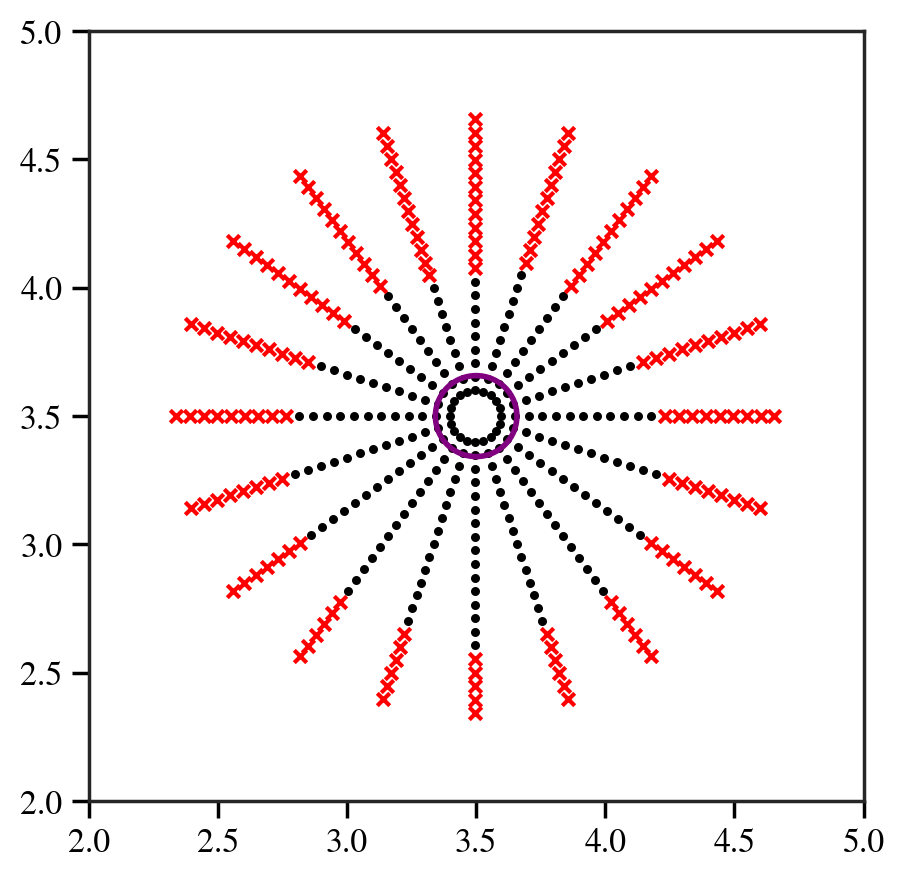

In [68]:
fig, ax = plt.subplots(figsize=(5, 5))
# model.plot(ax=ax, colorsBy="phase")
boxCenter = np.array([3.5, 3.5])
analRadius = speedV / np.abs(strengthK * np.sin(phaseLagA0))
disThres = (distanceD0 + analRadius) * 1.1
catchMap = pd.DataFrame(index=singleParticleDiss, columns=singleParticleAngles)

for model in tqdm(models):

    sa = StateAnalysis(model)    
    sinParPos = sa.totalPositionX[:, -1]
    sinParPha = sa.totalPhaseTheta[:, -1]

    alpha = 0.8
    # alpha = 1 - (model.singleParticleDis / singleParticleDiss.max()) * 0.5
    # color = "C2"
    color = cmap(model.singleParticleDis / singleParticleDiss.max())

    centerDis = sa.calc_replative_distance(sinParPos, boxCenter)
    breakThres = np.where(centerDis > disThres)[0]
    if len(breakThres) == 0:
        plt.scatter(sinParPos[0, 0], sinParPos[0, 1], 
                    color='black', s=5, marker="o")
        # plt.plot(sinParPos[:, 0], sinParPos[:, 1], color=color, lw=2, alpha=alpha)
        catchMap.loc[model.singleParticleDis, model.singleParticleAngle] = 0
        continue

    firstBreakThres = breakThres[0]
    plt.scatter(sinParPos[0, 0], sinParPos[0, 1], color="#FF0000", s=20, marker="x")
    catchMap.loc[model.singleParticleDis, model.singleParticleAngle] = 1
    
circle = plt.Circle(boxCenter, analRadius, color="purple", 
                    fill=False, lw=2, alpha=1, ls="-")
ax.add_artist(circle)
plt.ylim(2, 5)
plt.xlim(2, 5)
# plt.xlim(0, sa.totalPositionX.shape[0])

In [78]:
escapeDiss = catchMap.apply(lambda x: x[x.diff() == 1].index).values[0]
escapeDiss

array([0.7346316 , 0.78751757, 0.84040353, 0.8932895 , 0.8932895 ,
       0.94617547, 0.8932895 , 0.8932895 , 0.84040353, 0.78751757,
       0.7346316 , 0.68174563, 0.62885967, 0.62885967, 0.62885967,
       0.5759737 , 0.5759737 , 0.62885967, 0.62885967, 0.68174563])

In [52]:
model = PhaseLagPatternFormation(
    strengthK=20, distanceD0=1, phaseLagA0=0.6 * np.pi,
    # initPhaseTheta=np.zeros(1000), 
    omegaMin=0, deltaOmega=0,
    agentsNum=3000, dt=0.005,
    tqdm=True, savePath=SAVE_PATH, shotsnaps=1, 
    randomSeed=10, overWrite=False
)
sa = StateAnalysis(model)

In [53]:
def calc_lattice_constants(sa: StateAnalysis, plot: bool = False, lookIdx: int = -1):

    sa: StateAnalysis
    model = sa.model
    shift = np.array([0., 0.])
    analysisRadius = model.speedV / np.abs(model.strengthK * np.sin(model.phaseLagA0))

    classes, centers = sa.calc_classes_and_centers(classDistance=analysisRadius, lookIdx=lookIdx)
    if len(classes) > model.agentsNum * 0.2:
        # print(f"Too many classes: {len(classes)} > {model.agentsNum * 0.2}, skipping.")
        return [], []
    numInClasses = np.array([len(c) for c in classes])
    # zScoreNum = stats.zscore(numInClasses)
    # classes = [classes[c] for c in range(len(classes)) 
    #            if (zScoreNum[c] > -0.4) and (numInClasses[c] > 10)]
    numThres = np.median(numInClasses[numInClasses > 10]) * 0.
    classes = [classes[c] for c in range(len(classes))
               if (numInClasses[c] > max(numThres, 10))]
    centers = np.mod(centers + shift, model.boundaryLength)
    if len(classes) <= 1:
        # print("Not enough classes, skipping.")
        return [], []

    classCenters: List[np.ndarray] = []
    for c in classes:
        singleClassCenters = centers[c]

        maxDeltaX = np.abs(singleClassCenters[:, 0] - singleClassCenters[:, 0, np.newaxis]).max()
        subXShift = model.halfBoundaryLength if maxDeltaX > model.halfBoundaryLength else 0
        maxDeltaY = np.abs(singleClassCenters[:, 1] - singleClassCenters[:, 1, np.newaxis]).max()
        subYShift = model.halfBoundaryLength if maxDeltaY > model.halfBoundaryLength else 0

        singleClassCenters = np.mod(singleClassCenters - np.array([subXShift, subYShift]), model.boundaryLength)
        classCenter = np.mod(singleClassCenters.mean(axis=0) + np.array([subXShift, subYShift]), model.boundaryLength)
        classCenters.append(classCenter)
    classCenters: np.ndarray = np.array(classCenters)

    edges, ajdClassCenters = sa.calc_nearby_edges(
        classCenters=classCenters, 
        stdMulti=0.3,
        relativeDistance=False
    )

    classAnalRadius = list()

    for _, oscIdx in enumerate(classes):
        freqOmega: np.ndarray = sa.model.freqOmega[oscIdx]
        meanFreq = freqOmega.mean()
        analRadius = model.speedV / np.abs(meanFreq - model.strengthK * np.sin(model.phaseLagA0))
        
        classAnalRadius.append(analRadius)

    classAnalRadius = np.array(classAnalRadius)
    edgeDistances = np.array([
        sa.calc_replative_distance(ajdClassCenters[edge[0]], ajdClassCenters[edge[1]]) 
        for edge in edges
    ])

    if plot:
        sa.plot_spatial(colorsBy="phase", index=-1, shift=shift)
        plt.scatter(
            classCenters[:, 0], classCenters[:, 1],
            facecolor="white", s=30, edgecolor="black", lw=1.5
        )
        for edge in edges:
            plt.plot(ajdClassCenters[edge, 0], ajdClassCenters[edge, 1],
                    color="black", lw=1.2, alpha=0.3, linestyle=(0, (10, 2)), zorder=0)

    # print(len(classes))

    return classAnalRadius, edgeDistances

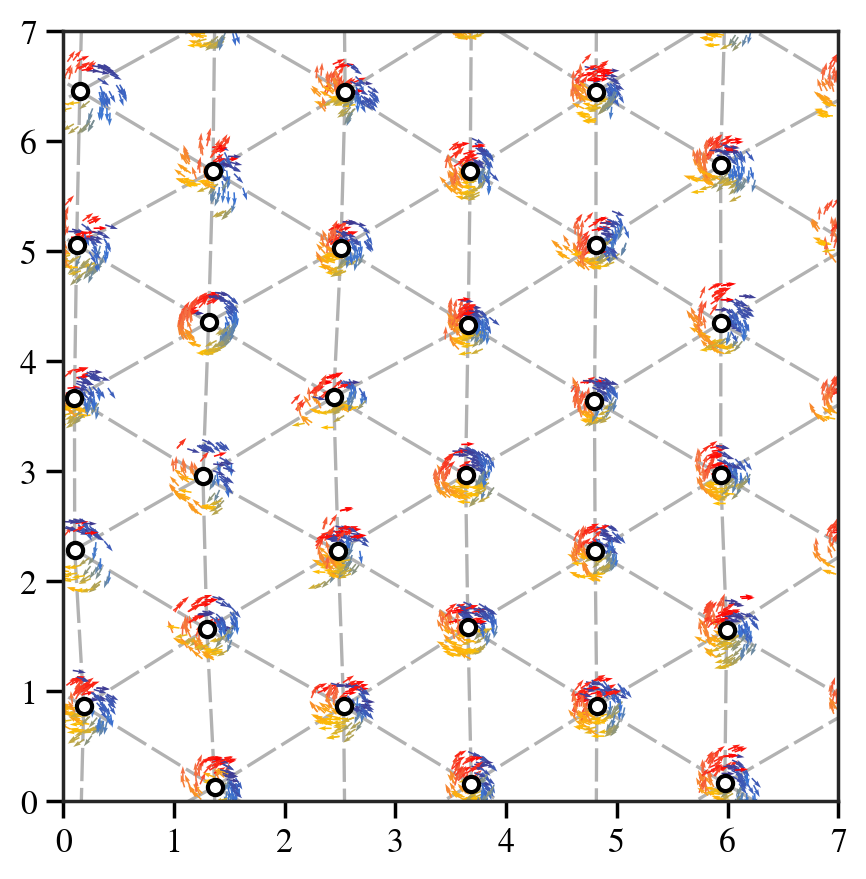

In [54]:
classAnalRadius, edgeDistances = calc_lattice_constants(sa, plot=True, lookIdx=-1)

In [100]:
np.mean(edgeDistances)

1.3736940858678421

In [79]:
analRadius

0.15771933363574006

In [101]:
distanceD0 + 2 * analRadius

1.3154386672714802

In [106]:
escapeDiss.mean() * 2

1.4904175870356031

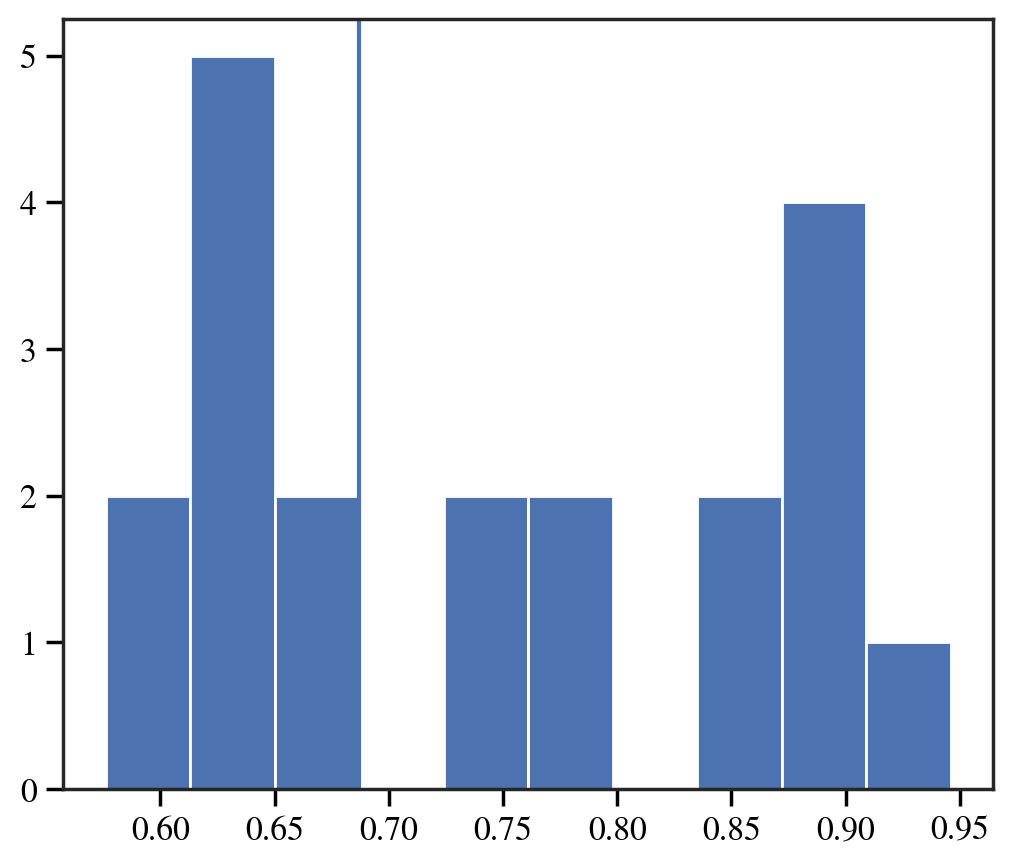

In [99]:
plt.hist(escapeDiss)
plt.axvline(np.mean(edgeDistances) / 2)

(array([ 27.,  66.,  96.,  45., 106., 117., 108.,  84.,  72.,  24.]),
 array([1.30891582, 1.32159575, 1.33427568, 1.34695561, 1.35963553,
        1.37231546, 1.38499539, 1.39767532, 1.41035525, 1.42303517,
        1.4357151 ]),
 <BarContainer object of 10 artists>)

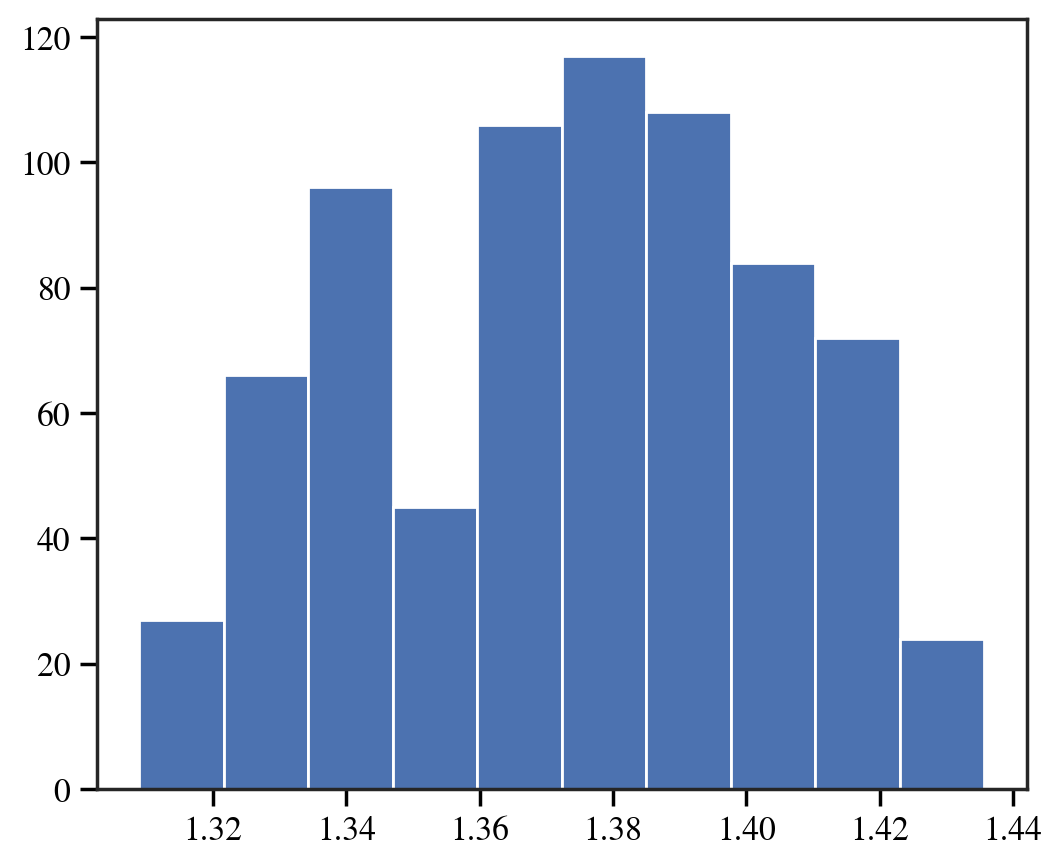

In [94]:
plt.hist(edgeDistances, bins=10)